# Local Setup Instructions

## Prerequisites Checklist

Before running this notebook, ensure you have completed the following setup:

- [ ] **Java 11 installed** and `JAVA_HOME` configured
  - macOS: `brew install openjdk@11`
  - Set: `export JAVA_HOME=$(/usr/libexec/java_home -v 11)`
- [ ] **Conda environment `fraud-shield` created and activated**
  - Create: `conda env create -f environment.yml`
  - Activate: `conda activate fraud-shield`
- [ ] **Data directories created**
  - `data/processed/` - for preprocessed data
  - `models/` - for saved models
  - `results/` - for model results
- [ ] **Preprocessed data available**
  - Run `02-local-preprocessing.ipynb` first
  - Preprocessed data should exist in `data/processed/`

## Environment Activation

```bash
conda activate fraud-shield
```

## Data Requirements

This notebook requires preprocessed data from the preprocessing notebook:
- `data/processed/train_preprocessed.parquet`
- `data/processed/val_preprocessed.parquet`
- `data/processed/test_preprocessed.parquet`

**Note:** This is a local execution version configured for the `fraud-shield` conda environment on your local machine.

# Supervised Models for Fraud Detection - Local Execution Version

**Notebook:** 04-local-supervised-models.ipynb
**Objective:** Train and evaluate XGBoost with iterative feature addition; select best model by validation F1; save model and results.

**Note:** Local execution - conda environment `fraud-shield`

## Pipeline

1. **Load** train/val/test from `data/processed/` (30 features from leak-proof preprocessing).
2. **Define feature sets** (priority lists if names match, else auto-filtered). Build feature sets: Top 3, 5, 7, 10, 15, 20, All.
3. **Baseline:** XGBoost with first 7 features; `scale_pos_weight` for imbalance; evaluate Train/Val/Test (F1, PR-AUC, ROC-AUC, confusion matrix).
4. **Iterative addition:** Train XGBoost for each feature set; compare validation F1.
5. **Additional models:** Logistic Regression, Random Forest, Optuna-tuned XGBoost.
6. **Save:** Best model, metadata, comparison CSV and results to `models/` and `results/`.

## Interpretation

The training data uses **natural distribution** (~0.58% fraud, no SMOTE). Class imbalance is handled via `scale_pos_weight`. Decision threshold is tuned on validation to maximize F1, then applied to test.

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Data Processing
import pandas as pd
import numpy as np

# Model Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)

# XGBoost
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import joblib
from datetime import datetime

print("All dependencies loaded successfully")

All dependencies loaded successfully


In [2]:
# ============================================================
# CONFIGURATION & PATHS
# ============================================================

# Path resolution for local execution
# Calculate PROJECT_ROOT based on notebook location
# Since notebook is in local_notebooks/, project root is parent directory
NOTEBOOK_DIR = Path.cwd()  # Current working directory
# If we're in local_notebooks/, go up one level to get project root
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    # Fallback: assume we're already at project root
    PROJECT_ROOT = NOTEBOOK_DIR

# Change working directory to project root for consistency
os.chdir(PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

# Create directories if they don't exist
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# Preprocessed data paths
PREPROCESSED_TRAIN_PATH = PROCESSED_DATA_DIR / 'train_preprocessed.parquet'
PREPROCESSED_VAL_PATH = PROCESSED_DATA_DIR / 'val_preprocessed.parquet'
PREPROCESSED_TEST_PATH = PROCESSED_DATA_DIR / 'test_preprocessed.parquet'
PREPROCESSER_PATH = MODELS_DIR / 'preprocessor.pkl'
FEATURE_NAMES_PATH = MODELS_DIR / 'feature_names.pkl'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Project root: /home/alireza/Desktop/projects/fraud-shield-ai
Data directory: /home/alireza/Desktop/projects/fraud-shield-ai/data
Models directory: /home/alireza/Desktop/projects/fraud-shield-ai/models
Results directory: /home/alireza/Desktop/projects/fraud-shield-ai/results


## 1. Load Preprocessed Data

In [3]:
# ============================================================
# LOAD PREPROCESSED DATA
# ============================================================

def load_preprocessed_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load preprocessed train, validation, and test datasets.
    
    Returns:
        Tuple of (train_df, val_df, test_df)
    """
    if not PREPROCESSED_TRAIN_PATH.exists():
        raise FileNotFoundError(
            f"Preprocessed data not found: {PREPROCESSED_TRAIN_PATH}\n"
            "Please run the preprocessing notebook (02-local-preprocessing.ipynb) first."
        )
    
    print("Loading preprocessed data...")
    train_df = pd.read_parquet(PREPROCESSED_TRAIN_PATH)
    val_df = pd.read_parquet(PREPROCESSED_VAL_PATH)
    test_df = pd.read_parquet(PREPROCESSED_TEST_PATH)
    
    print(f"\n✓ Data loaded successfully")
    print(f"  Train: {train_df.shape[0]:,} samples, {train_df.shape[1]} features")
    print(f"  Validation: {val_df.shape[0]:,} samples, {val_df.shape[1]} features")
    print(f"  Test: {test_df.shape[0]:,} samples, {test_df.shape[1]} features")
    
    print(f"\nFraud rates:")
    print(f"  Train: {train_df['is_fraud'].mean():.4%}")
    print(f"  Validation: {val_df['is_fraud'].mean():.4%}")
    print(f"  Test: {test_df['is_fraud'].mean():.4%}")
    
    return train_df, val_df, test_df

# Load data
train_df, val_df, test_df = load_preprocessed_data()

# Separate features and target (parquet columns are 0,1,... from Spark vector)
feature_cols = [col for col in train_df.columns if col != 'is_fraud']

# Rename numeric columns to real names from 02 preprocessing so Section 2 priority lists match
if FEATURE_NAMES_PATH.exists():
    with open(FEATURE_NAMES_PATH, 'rb') as f:
        _names = pickle.load(f)
    n = min(len(feature_cols), len(_names))
    rename_map = {str(i): _names[i] for i in range(n)}
    for df in (train_df, val_df, test_df):
        df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)
    feature_cols = [col for col in train_df.columns if col != 'is_fraud']

def display_feature_names(cols):
    return list(cols)

print(f"\nAvailable features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
if FEATURE_NAMES_PATH.exists():
    print(f"Columns renamed from feature_names.pkl")

Loading preprocessed data...

✓ Data loaded successfully
  Train: 1,034,987 samples, 31 features
  Validation: 122,480 samples, 31 features
  Test: 555,719 samples, 31 features

Fraud rates:
  Train: 0.5757%
  Validation: 0.5250%
  Test: 0.3860%

Available features: 30
Feature columns: ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online', 'temporal_risk_score', 'geographic_risk_score', 'card_risk_score', 'risk_tier', 'amt', 'city_pop', 'customer_merchant_distance_km', 'txn_count_last_1h', 'txn_count_last_24h', 'amt_relative_to_avg']
Columns renamed from feature_names.pkl


## 2. Define Feature Sets

In [4]:
# ============================================================
# FEATURE SET DEFINITIONS
# ============================================================

# Critical Priority features (from EDA findings)
CRITICAL_FEATURES = [
    'transaction_count_bin',
    'card_age_bin',
    'hour',
    'time_bin',
    'is_peak_fraud_hour',
    'is_new_card',
    'is_low_volume_card'
]

# High Priority features
HIGH_PRIORITY_FEATURES = [
    'category',
    'day_of_week',
    'month',
    'is_peak_fraud_day',
    'is_peak_fraud_season',
    'is_high_risk_category',
    'card_age_days',
    'transaction_count'
]

# Interaction features
INTERACTION_FEATURES = [
    'evening_high_amount',
    'evening_online_shopping',
    'large_city_evening',
    'new_card_evening',
    'high_amount_online'
]

# Enriched features
ENRICHED_FEATURES = [
    'temporal_risk_score',
    'geographic_risk_score',
    'card_risk_score',
    'risk_tier'
]

# Filter to only features that exist in the dataset
def filter_available_features(feature_list: List[str], available_cols: List[str]) -> List[str]:
    """Filter feature list to only include features that exist in the dataset."""
    return [f for f in feature_list if f in available_cols]

CRITICAL_FEATURES_AVAIL = filter_available_features(CRITICAL_FEATURES, feature_cols)
HIGH_PRIORITY_FEATURES_AVAIL = filter_available_features(HIGH_PRIORITY_FEATURES, feature_cols)
INTERACTION_FEATURES_AVAIL = filter_available_features(INTERACTION_FEATURES, feature_cols)
ENRICHED_FEATURES_AVAIL = filter_available_features(ENRICHED_FEATURES, feature_cols)

print("Feature Set Summary:")
print(f"  Critical Priority: {len(CRITICAL_FEATURES_AVAIL)}/{len(CRITICAL_FEATURES)} available")
print(f"  High Priority: {len(HIGH_PRIORITY_FEATURES_AVAIL)}/{len(HIGH_PRIORITY_FEATURES)} available")
print(f"  Interaction: {len(INTERACTION_FEATURES_AVAIL)}/{len(INTERACTION_FEATURES)} available")
print(f"  Enriched: {len(ENRICHED_FEATURES_AVAIL)}/{len(ENRICHED_FEATURES)} available")

if CRITICAL_FEATURES_AVAIL:
    print(f"\nCritical features to use: {CRITICAL_FEATURES_AVAIL}")
else:
    print("\n⚠ Warning: No critical features found in dataset!")

Feature Set Summary:
  Critical Priority: 7/7 available
  High Priority: 8/8 available
  Interaction: 5/5 available
  Enriched: 4/4 available

Critical features to use: ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card']


## 3. Evaluation Metrics Functions

In [5]:
# ============================================================
# EVALUATION METRICS FUNCTIONS
# ============================================================

def find_best_threshold(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    metric: str = "f1"
) -> Tuple[float, float]:
    """Threshold that maximizes F1 on (y_true, y_pred_proba). Returns (best_threshold, best_f1)."""
    prec, rec, thresh = precision_recall_curve(y_true, y_pred_proba)
    thresh = np.append(thresh, 1.0)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-10)
    idx = np.nanargmax(f1_scores)
    return float(thresh[idx]), float(f1_scores[idx])

def evaluate_model(
    model: xgb.XGBClassifier,
    X: np.ndarray,
    y: np.ndarray,
    dataset_name: str = "Dataset",
    threshold: Optional[float] = None
) -> Dict[str, float]:
    """
    Evaluate model performance on a dataset.
    
    Args:
        model: Trained XGBoost model
        X: Feature matrix
        y: True labels
        dataset_name: Name of dataset for display
    
    Returns:
        Dictionary of evaluation metrics
    """
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= (threshold if threshold is not None else 0.5)).astype(int)

    metrics = {
        'f1_score': f1_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y, y_pred_proba),
        'pr_auc': average_precision_score(y, y_pred_proba)
    }
    
    print(f"\n{dataset_name} Performance:" + (f" (threshold={threshold:.4f})" if threshold is not None else ""))
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  PR-AUC: {metrics['pr_auc']:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    n_neg = cm[0, 0] + cm[0, 1]
    fpr = cm[0, 1] / n_neg if n_neg else 0.0
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
    print(f"    FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")
    print(f"    False Positive Rate: {fpr:.4%}")
    
    return metrics

def plot_precision_recall_curve(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    dataset_name: str = "Dataset",
    ax: Optional[plt.Axes] = None
) -> None:
    """Plot Precision-Recall curve."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(recall, precision, label=f'{dataset_name} (AUC={pr_auc:.4f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_roc_curve(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    dataset_name: str = "Dataset",
    ax: Optional[plt.Axes] = None
) -> None:
    """Plot ROC curve."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, label=f'{dataset_name} (AUC={roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

print("Evaluation functions defined")

Evaluation functions defined


## 4. Baseline Model: XGBoost with Critical Priority Features

In [6]:
# ============================================================
# BASELINE MODEL: XGBOOST WITH CRITICAL FEATURES ONLY
# ============================================================

# Prepare data with Critical Priority features only
baseline_features = CRITICAL_FEATURES_AVAIL if CRITICAL_FEATURES_AVAIL else feature_cols[:7]

X_train_baseline = train_df[baseline_features].values
y_train_baseline = train_df['is_fraud'].values

X_val_baseline = val_df[baseline_features].values
y_val_baseline = val_df['is_fraud'].values

X_test_baseline = test_df[baseline_features].values
y_test_baseline = test_df['is_fraud'].values

print(f"Baseline model using {len(baseline_features)} features:")
print(f"  Features: {display_feature_names(baseline_features)}")
print(f"\nData shapes:")
print(f"  Train: X={X_train_baseline.shape}, y={y_train_baseline.shape}")
print(f"  Validation: X={X_val_baseline.shape}, y={y_val_baseline.shape}")
print(f"  Test: X={X_test_baseline.shape}, y={y_test_baseline.shape}")

Baseline model using 7 features:
  Features: ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card']

Data shapes:
  Train: X=(1034987, 7), y=(1034987,)
  Validation: X=(122480, 7), y=(122480,)
  Test: X=(555719, 7), y=(555719,)


In [7]:
# ============================================================
# TRAIN BASELINE XGBOOST MODEL WITH CLASS WEIGHTS
# ============================================================

# Calculate class weights (inverse of class frequency)
n_samples = len(y_train_baseline)
n_fraud = y_train_baseline.sum()
n_legitimate = n_samples - n_fraud

# XGBoost uses scale_pos_weight parameter
# scale_pos_weight = (number of negative samples) / (number of positive samples)
scale_pos_weight = n_legitimate / n_fraud

print(f"Class distribution:")
print(f"  Legitimate: {n_legitimate:,} ({n_legitimate/n_samples:.2%})")
print(f"  Fraud: {n_fraud:,} ({n_fraud/n_samples:.2%})")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")

# Train baseline model
baseline_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining baseline model...")
baseline_model.fit(
    X_train_baseline,
    y_train_baseline,
    eval_set=[(X_val_baseline, y_val_baseline)],
    verbose=False
)

print("✓ Baseline model trained")

Class distribution:
  Legitimate: 1,029,029 (99.42%)
  Fraud: 5,958 (0.58%)
  scale_pos_weight: 172.71

Training baseline model...


✓ Baseline model trained


In [8]:
# ============================================================
# EVALUATE BASELINE MODEL
# ============================================================

baseline_train_metrics = evaluate_model(baseline_model, X_train_baseline, y_train_baseline, "Train")
baseline_val_metrics = evaluate_model(baseline_model, X_val_baseline, y_val_baseline, "Validation")
baseline_test_metrics = evaluate_model(baseline_model, X_test_baseline, y_test_baseline, "Test")


Train Performance:
  F1-Score: 0.0424
  Precision: 0.0218
  Recall: 0.8337
  ROC-AUC: 0.8934
  PR-AUC: 0.1081

  Confusion Matrix:
    TN: 805,847  FP: 223,182
    FN: 991  TP: 4,967
    False Positive Rate: 21.6886%

Validation Performance:
  F1-Score: 0.0394
  Precision: 0.0202
  Recall: 0.7714
  ROC-AUC: 0.8683
  PR-AUC: 0.1612

  Confusion Matrix:
    TN: 97,776  FP: 24,061
    FN: 147  TP: 496
    False Positive Rate: 19.7485%



Test Performance:
  F1-Score: 0.0092
  Precision: 0.0047
  Recall: 0.3800
  ROC-AUC: 0.5774
  PR-AUC: 0.0048

  Confusion Matrix:
    TN: 379,993  FP: 173,581
    FN: 1,330  TP: 815
    False Positive Rate: 31.3564%


### Threshold Tuning (Best Practice)

At the **default threshold of 0.5**, precision/recall can be misleading because the fraud prevalence is very low (~0.58% train, ~0.39% test). The fix is to tune the **decision threshold on validation** (maximize F1) and report **test metrics at that threshold**. ROC-AUC and PR-AUC are threshold-invariant and remain valid regardless.

In [9]:
# Threshold tuning: maximize validation F1, then evaluate test at that threshold
y_val_proba_baseline = baseline_model.predict_proba(X_val_baseline)[:, 1]
best_threshold, best_val_f1 = find_best_threshold(y_val_baseline, y_val_proba_baseline, metric="f1")
print(f"Best validation threshold (max F1): {best_threshold:.4f} (val F1 = {best_val_f1:.4f})")

print("\n--- Metrics at tuned threshold ---")
evaluate_model(baseline_model, X_train_baseline, y_train_baseline, "Train", threshold=best_threshold)
evaluate_model(baseline_model, X_val_baseline, y_val_baseline, "Validation", threshold=best_threshold)
evaluate_model(baseline_model, X_test_baseline, y_test_baseline, "Test", threshold=best_threshold)

Best validation threshold (max F1): 0.9428 (val F1 = 0.1971)

--- Metrics at tuned threshold ---



Train Performance: (threshold=0.9428)
  F1-Score: 0.1651
  Precision: 0.2014
  Recall: 0.1400
  ROC-AUC: 0.8934
  PR-AUC: 0.1081

  Confusion Matrix:
    TN: 1,025,721  FP: 3,308
    FN: 5,124  TP: 834
    False Positive Rate: 0.3215%

Validation Performance: (threshold=0.9428)
  F1-Score: 0.1971
  Precision: 0.4339
  Recall: 0.1275
  ROC-AUC: 0.8683
  PR-AUC: 0.1612

  Confusion Matrix:
    TN: 121,730  FP: 107
    FN: 561  TP: 82
    False Positive Rate: 0.0878%



Test Performance: (threshold=0.9428)
  F1-Score: 0.0063
  Precision: 0.0057
  Recall: 0.0070
  ROC-AUC: 0.5774
  PR-AUC: 0.0048

  Confusion Matrix:
    TN: 550,975  FP: 2,599
    FN: 2,130  TP: 15
    False Positive Rate: 0.4695%


{'f1_score': 0.006303845345660853,
 'precision': 0.005738332058148432,
 'recall': 0.006993006993006993,
 'roc_auc': 0.5773584065799742,
 'pr_auc': 0.004779377657485102}

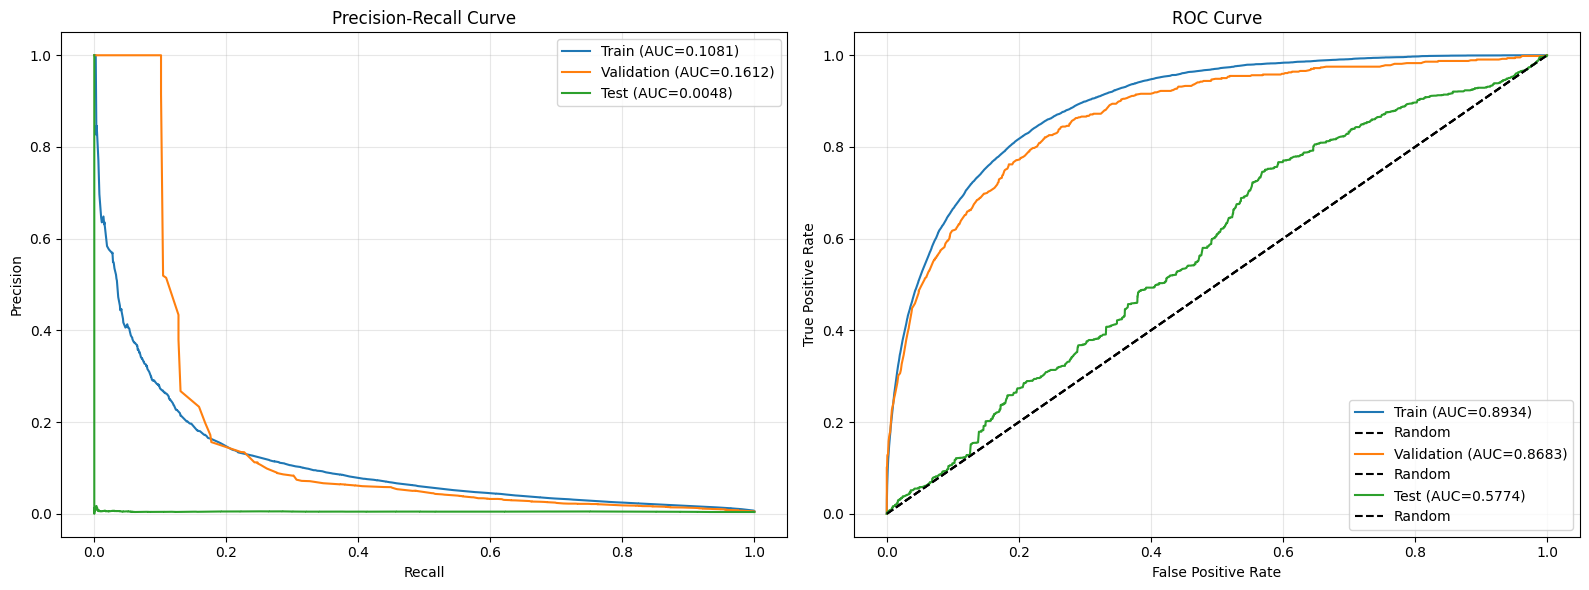

In [10]:
# ============================================================
# VISUALIZE BASELINE MODEL PERFORMANCE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall curves
y_train_proba = baseline_model.predict_proba(X_train_baseline)[:, 1]
y_val_proba = baseline_model.predict_proba(X_val_baseline)[:, 1]
y_test_proba = baseline_model.predict_proba(X_test_baseline)[:, 1]

plot_precision_recall_curve(y_train_baseline, y_train_proba, "Train", axes[0])
plot_precision_recall_curve(y_val_baseline, y_val_proba, "Validation", axes[0])
plot_precision_recall_curve(y_test_baseline, y_test_proba, "Test", axes[0])

# ROC curves
plot_roc_curve(y_train_baseline, y_train_proba, "Train", axes[1])
plot_roc_curve(y_val_baseline, y_val_proba, "Validation", axes[1])
plot_roc_curve(y_test_baseline, y_test_proba, "Test", axes[1])

plt.tight_layout()
plt.show()

Baseline Model Feature Importance:
              feature  importance
          is_new_card    0.471570
transaction_count_bin    0.188006
             time_bin    0.164127
         card_age_bin    0.067863
                 hour    0.061822
   is_peak_fraud_hour    0.046611
   is_low_volume_card    0.000000


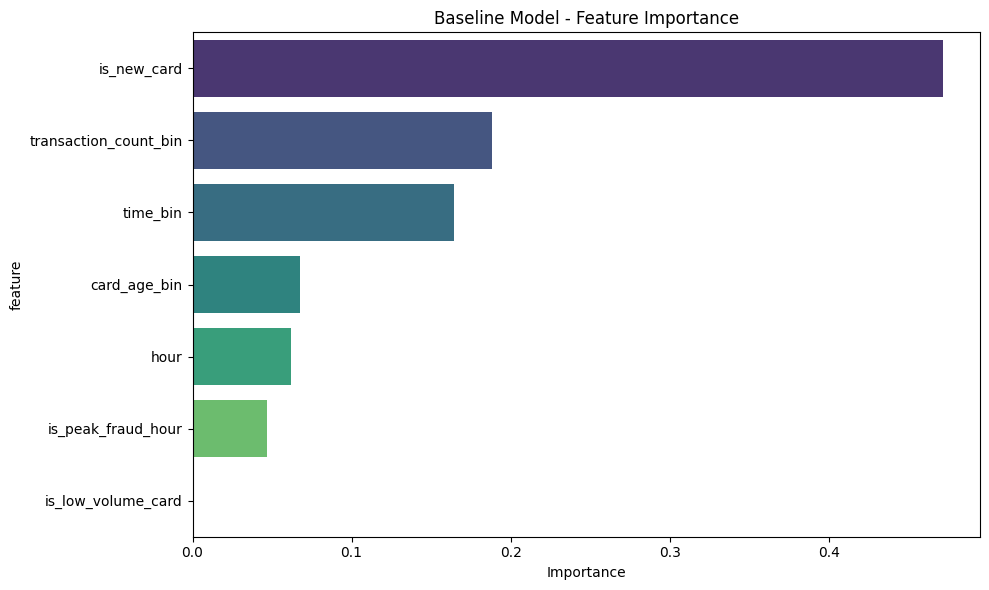


✓ Baseline model evaluation complete


In [11]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS (BASELINE)
# ============================================================

feature_importance = baseline_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': baseline_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df = importance_df.copy()
importance_df['feature'] = display_feature_names(importance_df['feature'].tolist())

print("Baseline Model Feature Importance:")
print(importance_df.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Baseline Model - Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Store baseline results
baseline_results = {
    'features': baseline_features,
    'train_metrics': baseline_train_metrics,
    'val_metrics': baseline_val_metrics,
    'test_metrics': baseline_test_metrics,
    'feature_importance': importance_df.to_dict('records')
}

print("\n✓ Baseline model evaluation complete")

## 5. Iterative Feature Addition

In [12]:
# ============================================================
# ITERATIVE FEATURE ADDITION FUNCTION
# ============================================================

def train_and_evaluate_model(
    features: List[str],
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    scale_pos_weight: float
) -> Tuple[xgb.XGBClassifier, Dict[str, Dict[str, float]], pd.DataFrame]:
    """
    Train XGBoost model with given features and return metrics.
    Uses threshold tuning on validation set for better test metrics.
    
    Returns:
        Tuple of (model, metrics_dict, feature_importance_df)
    """
    # Prepare data
    X_train = train_df[features].values
    y_train = train_df['is_fraud'].values
    X_val = val_df[features].values
    y_val = val_df['is_fraud'].values
    X_test = test_df[features].values
    y_test = test_df['is_fraud'].values
    
    # Train model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Find optimal threshold on validation set (maximize F1)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh, best_val_f1 = find_best_threshold(y_val, y_val_proba, metric='f1')
    print(f"  Optimal threshold (max val F1): {best_thresh:.4f}")
    
    # Evaluate at default threshold (for comparison)
    print("\n  --- Metrics at default threshold (0.5) ---")
    train_metrics_default = evaluate_model(model, X_train, y_train, "Train")
    val_metrics_default = evaluate_model(model, X_val, y_val, "Validation")
    test_metrics_default = evaluate_model(model, X_test, y_test, "Test")
    
    # Evaluate at optimal threshold
    print(f"\n  --- Metrics at optimal threshold ({best_thresh:.4f}) ---")
    train_metrics = evaluate_model(model, X_train, y_train, "Train", threshold=best_thresh)
    val_metrics = evaluate_model(model, X_val, y_val, "Validation", threshold=best_thresh)
    test_metrics = evaluate_model(model, X_test, y_test, "Test", threshold=best_thresh)
    
    # Store optimal threshold in metrics
    metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'optimal_threshold': best_thresh,
        'train_default': train_metrics_default,
        'val_default': val_metrics_default,
        'test_default': test_metrics_default
    }
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return model, metrics, importance_df

print("Iterative feature addition function defined (with threshold tuning)")

Iterative feature addition function defined (with threshold tuning)


In [13]:
# ============================================================
# ITERATIVE FEATURE ADDITION: BUILD FEATURE SETS
# ============================================================

# Build progressive feature sets from feature_cols (Section 1)
n_total = len(feature_cols)
step_sizes = [k for k in (3, 5, 7, 10, 15, 20, n_total) if k <= n_total and k >= 1]
step_sizes = sorted(set(step_sizes))

feature_sets = []
for k in step_sizes:
    feats = feature_cols[:k]
    name = f"Top {k}" if k < n_total else "All"
    feature_sets.append({"name": name, "features": feats})

print(f"Feature addition sequence ({len(feature_sets)} steps):")
for i, fs in enumerate(feature_sets, 1):
    print(f"  Step {i}: {fs['name']} ({len(fs['features'])} features)")

Feature addition sequence (7 steps):
  Step 1: Top 3 (3 features)
  Step 2: Top 5 (5 features)
  Step 3: Top 7 (7 features)
  Step 4: Top 10 (10 features)
  Step 5: Top 15 (15 features)
  Step 6: Top 20 (20 features)
  Step 7: All (30 features)


In [14]:
# ============================================================
# ITERATIVE FEATURE ADDITION: TRAIN MODELS
# ============================================================

all_results = []
all_models = []

print("=" * 80)
print("ITERATIVE FEATURE ADDITION")
print("=" * 80)

for i, feature_set in enumerate(feature_sets):
    print(f"\n{'='*80}")
    print(f"Step {i+1}/{len(feature_sets)}: {feature_set['name']}")
    print(f"{'='*80}")
    print(f"Features ({len(feature_set['features'])}): {display_feature_names(feature_set['features'])}")
    
    # Train and evaluate
    model, metrics, importance_df = train_and_evaluate_model(
        feature_set['features'],
        train_df,
        val_df,
        test_df,
        scale_pos_weight
    )
    importance_df = importance_df.copy()
    importance_df['feature'] = display_feature_names(importance_df['feature'].tolist())
    
    # Store results
    result = {
        'step': i + 1,
        'name': feature_set['name'],
        'n_features': len(feature_set['features']),
        'features': feature_set['features'],
        'metrics': metrics,
        'feature_importance': importance_df,
        'model': model
    }
    
    all_results.append(result)
    all_models.append(model)
    
    # Print improvement over previous step
    if i > 0:
        prev_val_f1 = all_results[i-1]['metrics']['val']['f1_score']
        curr_val_f1 = metrics['val']['f1_score']
        improvement = curr_val_f1 - prev_val_f1
        print(f"\n  Improvement in Validation F1: {improvement:+.4f} ({improvement/prev_val_f1*100:+.2f}%)")

print(f"\n{'='*80}")
print("ITERATIVE FEATURE ADDITION COMPLETE")
print(f"{'='*80}")

ITERATIVE FEATURE ADDITION

Step 1/7: Top 3
Features (3): ['transaction_count_bin', 'card_age_bin', 'hour']


  Optimal threshold (max val F1): 0.7803

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0320
  Precision: 0.0164
  Recall: 0.6801
  ROC-AUC: 0.7890
  PR-AUC: 0.0308

  Confusion Matrix:
    TN: 785,445  FP: 243,584
    FN: 1,906  TP: 4,052
    False Positive Rate: 23.6712%

Validation Performance:
  F1-Score: 0.0361
  Precision: 0.0186
  Recall: 0.6641
  ROC-AUC: 0.7885
  PR-AUC: 0.1187

  Confusion Matrix:
    TN: 99,261  FP: 22,576
    FN: 216  TP: 427
    False Positive Rate: 18.5297%



Test Performance:
  F1-Score: 0.0106
  Precision: 0.0054
  Recall: 0.6056
  ROC-AUC: 0.6308
  PR-AUC: 0.0089

  Confusion Matrix:
    TN: 312,533  FP: 241,041
    FN: 846  TP: 1,299
    False Positive Rate: 43.5427%

  --- Metrics at optimal threshold (0.7803) ---



Train Performance: (threshold=0.7803)
  F1-Score: 0.0705
  Precision: 0.0443
  Recall: 0.1719
  ROC-AUC: 0.7890
  PR-AUC: 0.0308

  Confusion Matrix:
    TN: 1,006,941  FP: 22,088
    FN: 4,934  TP: 1,024
    False Positive Rate: 2.1465%

Validation Performance: (threshold=0.7803)
  F1-Score: 0.1913
  Precision: 1.0000
  Recall: 0.1058
  ROC-AUC: 0.7885
  PR-AUC: 0.1187

  Confusion Matrix:
    TN: 121,837  FP: 0
    FN: 575  TP: 68
    False Positive Rate: 0.0000%



Test Performance: (threshold=0.7803)
  F1-Score: 0.0211
  Precision: 0.0113
  Recall: 0.1646
  ROC-AUC: 0.6308
  PR-AUC: 0.0089

  Confusion Matrix:
    TN: 522,675  FP: 30,899
    FN: 1,792  TP: 353
    False Positive Rate: 5.5817%

Step 2/7: Top 5
Features (5): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour']


  Optimal threshold (max val F1): 0.9214

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0393
  Precision: 0.0202
  Recall: 0.8036
  ROC-AUC: 0.8642
  PR-AUC: 0.0748

  Confusion Matrix:
    TN: 796,413  FP: 232,616
    FN: 1,170  TP: 4,788
    False Positive Rate: 22.6054%

Validation Performance:
  F1-Score: 0.0355
  Precision: 0.0182
  Recall: 0.7527
  ROC-AUC: 0.8445
  PR-AUC: 0.1375

  Confusion Matrix:
    TN: 95,682  FP: 26,155
    FN: 159  TP: 484
    False Positive Rate: 21.4672%



Test Performance:
  F1-Score: 0.0128
  Precision: 0.0065
  Recall: 0.6224
  ROC-AUC: 0.7011
  PR-AUC: 0.0170

  Confusion Matrix:
    TN: 349,143  FP: 204,431
    FN: 810  TP: 1,335
    False Positive Rate: 36.9293%

  --- Metrics at optimal threshold (0.9214) ---



Train Performance: (threshold=0.9214)
  F1-Score: 0.1382
  Precision: 0.1511
  Recall: 0.1272
  ROC-AUC: 0.8642
  PR-AUC: 0.0748

  Confusion Matrix:
    TN: 1,024,772  FP: 4,257
    FN: 5,200  TP: 758
    False Positive Rate: 0.4137%

Validation Performance: (threshold=0.9214)
  F1-Score: 0.1878
  Precision: 0.6283
  Recall: 0.1104
  ROC-AUC: 0.8445
  PR-AUC: 0.1375

  Confusion Matrix:
    TN: 121,795  FP: 42
    FN: 572  TP: 71
    False Positive Rate: 0.0345%



Test Performance: (threshold=0.9214)
  F1-Score: 0.0403
  Precision: 0.0298
  Recall: 0.0625
  ROC-AUC: 0.7011
  PR-AUC: 0.0170

  Confusion Matrix:
    TN: 549,208  FP: 4,366
    FN: 2,011  TP: 134
    False Positive Rate: 0.7887%

  Improvement in Validation F1: -0.0034 (-1.80%)

Step 3/7: Top 7
Features (7): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card']


  Optimal threshold (max val F1): 0.9428

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0424
  Precision: 0.0218
  Recall: 0.8337
  ROC-AUC: 0.8934
  PR-AUC: 0.1081

  Confusion Matrix:
    TN: 805,847  FP: 223,182
    FN: 991  TP: 4,967
    False Positive Rate: 21.6886%

Validation Performance:
  F1-Score: 0.0394
  Precision: 0.0202
  Recall: 0.7714
  ROC-AUC: 0.8683
  PR-AUC: 0.1612

  Confusion Matrix:
    TN: 97,776  FP: 24,061
    FN: 147  TP: 496
    False Positive Rate: 19.7485%



Test Performance:
  F1-Score: 0.0092
  Precision: 0.0047
  Recall: 0.3800
  ROC-AUC: 0.5774
  PR-AUC: 0.0048

  Confusion Matrix:
    TN: 379,993  FP: 173,581
    FN: 1,330  TP: 815
    False Positive Rate: 31.3564%

  --- Metrics at optimal threshold (0.9428) ---



Train Performance: (threshold=0.9428)
  F1-Score: 0.1651
  Precision: 0.2014
  Recall: 0.1400
  ROC-AUC: 0.8934
  PR-AUC: 0.1081

  Confusion Matrix:
    TN: 1,025,721  FP: 3,308
    FN: 5,124  TP: 834
    False Positive Rate: 0.3215%

Validation Performance: (threshold=0.9428)
  F1-Score: 0.1971
  Precision: 0.4339
  Recall: 0.1275
  ROC-AUC: 0.8683
  PR-AUC: 0.1612

  Confusion Matrix:
    TN: 121,730  FP: 107
    FN: 561  TP: 82
    False Positive Rate: 0.0878%



Test Performance: (threshold=0.9428)
  F1-Score: 0.0063
  Precision: 0.0057
  Recall: 0.0070
  ROC-AUC: 0.5774
  PR-AUC: 0.0048

  Confusion Matrix:
    TN: 550,975  FP: 2,599
    FN: 2,130  TP: 15
    False Positive Rate: 0.4695%

  Improvement in Validation F1: +0.0093 (+4.94%)

Step 4/7: Top 10
Features (10): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month']


  Optimal threshold (max val F1): 0.9518

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0445
  Precision: 0.0229
  Recall: 0.8411
  ROC-AUC: 0.9006
  PR-AUC: 0.1199

  Confusion Matrix:
    TN: 814,964  FP: 214,065
    FN: 947  TP: 5,011
    False Positive Rate: 20.8026%

Validation Performance:
  F1-Score: 0.0403
  Precision: 0.0207
  Recall: 0.7589
  ROC-AUC: 0.8683
  PR-AUC: 0.1589

  Confusion Matrix:
    TN: 98,766  FP: 23,071
    FN: 155  TP: 488
    False Positive Rate: 18.9360%



Test Performance:
  F1-Score: 0.0091
  Precision: 0.0046
  Recall: 0.3608
  ROC-AUC: 0.5794
  PR-AUC: 0.0047

  Confusion Matrix:
    TN: 385,987  FP: 167,587
    FN: 1,371  TP: 774
    False Positive Rate: 30.2736%

  --- Metrics at optimal threshold (0.9518) ---



Train Performance: (threshold=0.9518)
  F1-Score: 0.1572
  Precision: 0.2760
  Recall: 0.1099
  ROC-AUC: 0.9006
  PR-AUC: 0.1199

  Confusion Matrix:
    TN: 1,027,311  FP: 1,718
    FN: 5,303  TP: 655
    False Positive Rate: 0.1670%

Validation Performance: (threshold=0.9518)
  F1-Score: 0.1826
  Precision: 0.8250
  Recall: 0.1026
  ROC-AUC: 0.8683
  PR-AUC: 0.1589

  Confusion Matrix:
    TN: 121,823  FP: 14
    FN: 577  TP: 66
    False Positive Rate: 0.0115%



Test Performance: (threshold=0.9518)
  F1-Score: 0.0073
  Precision: 0.0106
  Recall: 0.0056
  ROC-AUC: 0.5794
  PR-AUC: 0.0047

  Confusion Matrix:
    TN: 552,452  FP: 1,122
    FN: 2,133  TP: 12
    False Positive Rate: 0.2027%

  Improvement in Validation F1: -0.0145 (-7.38%)

Step 5/7: Top 15
Features (15): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count']


  Optimal threshold (max val F1): 0.9657

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0508
  Precision: 0.0262
  Recall: 0.8662
  ROC-AUC: 0.9197
  PR-AUC: 0.2030

  Confusion Matrix:
    TN: 836,982  FP: 192,047
    FN: 797  TP: 5,161
    False Positive Rate: 18.6629%

Validation Performance:
  F1-Score: 0.0470
  Precision: 0.0244
  Recall: 0.6236
  ROC-AUC: 0.8389
  PR-AUC: 0.1631

  Confusion Matrix:
    TN: 105,803  FP: 16,034
    FN: 242  TP: 401
    False Positive Rate: 13.1602%



Test Performance:
  F1-Score: 0.0089
  Precision: 0.0045
  Recall: 0.3002
  ROC-AUC: 0.5797
  PR-AUC: 0.0064

  Confusion Matrix:
    TN: 411,876  FP: 141,698
    FN: 1,501  TP: 644
    False Positive Rate: 25.5969%

  --- Metrics at optimal threshold (0.9657) ---



Train Performance: (threshold=0.9657)
  F1-Score: 0.1700
  Precision: 0.8725
  Recall: 0.0942
  ROC-AUC: 0.9197
  PR-AUC: 0.2030

  Confusion Matrix:
    TN: 1,028,947  FP: 82
    FN: 5,397  TP: 561
    False Positive Rate: 0.0080%

Validation Performance: (threshold=0.9657)
  F1-Score: 0.2089
  Precision: 1.0000
  Recall: 0.1166
  ROC-AUC: 0.8389
  PR-AUC: 0.1631

  Confusion Matrix:
    TN: 121,837  FP: 0
    FN: 568  TP: 75
    False Positive Rate: 0.0000%



Test Performance: (threshold=0.9657)
  F1-Score: 0.0250
  Precision: 0.0148
  Recall: 0.0807
  ROC-AUC: 0.5797
  PR-AUC: 0.0064

  Confusion Matrix:
    TN: 542,036  FP: 11,538
    FN: 1,972  TP: 173
    False Positive Rate: 2.0843%

  Improvement in Validation F1: +0.0263 (+14.43%)

Step 6/7: Top 20
Features (20): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online']


  Optimal threshold (max val F1): 0.9615

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0856
  Precision: 0.0450
  Recall: 0.8793
  ROC-AUC: 0.9578
  PR-AUC: 0.4923

  Confusion Matrix:
    TN: 917,881  FP: 111,148
    FN: 719  TP: 5,239
    False Positive Rate: 10.8013%

Validation Performance:
  F1-Score: 0.0629
  Precision: 0.0330
  Recall: 0.6610
  ROC-AUC: 0.8810
  PR-AUC: 0.4487

  Confusion Matrix:
    TN: 109,382  FP: 12,455
    FN: 218  TP: 425
    False Positive Rate: 10.2227%



Test Performance:
  F1-Score: 0.0255
  Precision: 0.0131
  Recall: 0.4266
  ROC-AUC: 0.7077
  PR-AUC: 0.0384

  Confusion Matrix:
    TN: 484,730  FP: 68,844
    FN: 1,230  TP: 915
    False Positive Rate: 12.4363%

  --- Metrics at optimal threshold (0.9615) ---



Train Performance: (threshold=0.9615)
  F1-Score: 0.5043
  Precision: 0.6678
  Recall: 0.4052
  ROC-AUC: 0.9578
  PR-AUC: 0.4923

  Confusion Matrix:
    TN: 1,027,828  FP: 1,201
    FN: 3,544  TP: 2,414
    False Positive Rate: 0.1167%

Validation Performance: (threshold=0.9615)
  F1-Score: 0.5349
  Precision: 0.7095
  Recall: 0.4292
  ROC-AUC: 0.8810
  PR-AUC: 0.4487

  Confusion Matrix:
    TN: 121,724  FP: 113
    FN: 367  TP: 276
    False Positive Rate: 0.0927%



Test Performance: (threshold=0.9615)
  F1-Score: 0.0763
  Precision: 0.0485
  Recall: 0.1790
  ROC-AUC: 0.7077
  PR-AUC: 0.0384

  Confusion Matrix:
    TN: 546,039  FP: 7,535
    FN: 1,761  TP: 384
    False Positive Rate: 1.3612%

  Improvement in Validation F1: +0.3260 (+156.03%)

Step 7/7: All
Features (30): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online', 'temporal_risk_score', 'geographic_risk_score', 'card_risk_score', 'risk_tier', 'amt', 'city_pop', 'customer_merchant_distance_km', 'txn_count_last_1h', 'txn_count_last_24h', 'amt_relative_to_avg']


  Optimal threshold (max val F1): 0.9784

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.4243
  Precision: 0.2700
  Recall: 0.9911
  ROC-AUC: 0.9991
  PR-AUC: 0.9079

  Confusion Matrix:
    TN: 1,013,060  FP: 15,969
    FN: 53  TP: 5,905
    False Positive Rate: 1.5519%

Validation Performance:
  F1-Score: 0.3816
  Precision: 0.2374
  Recall: 0.9720
  ROC-AUC: 0.9980
  PR-AUC: 0.8666

  Confusion Matrix:
    TN: 119,829  FP: 2,008
    FN: 18  TP: 625
    False Positive Rate: 1.6481%



Test Performance:
  F1-Score: 0.1891
  Precision: 0.1060
  Recall: 0.8769
  ROC-AUC: 0.9876
  PR-AUC: 0.5364

  Confusion Matrix:
    TN: 537,704  FP: 15,870
    FN: 264  TP: 1,881
    False Positive Rate: 2.8668%

  --- Metrics at optimal threshold (0.9784) ---



Train Performance: (threshold=0.9784)
  F1-Score: 0.8207
  Precision: 0.8458
  Recall: 0.7971
  ROC-AUC: 0.9991
  PR-AUC: 0.9079

  Confusion Matrix:
    TN: 1,028,163  FP: 866
    FN: 1,209  TP: 4,749
    False Positive Rate: 0.0842%

Validation Performance: (threshold=0.9784)
  F1-Score: 0.7899
  Precision: 0.8254
  Recall: 0.7574
  ROC-AUC: 0.9980
  PR-AUC: 0.8666

  Confusion Matrix:
    TN: 121,734  FP: 103
    FN: 156  TP: 487
    False Positive Rate: 0.0845%



Test Performance: (threshold=0.9784)
  F1-Score: 0.5598
  Precision: 0.6059
  Recall: 0.5203
  ROC-AUC: 0.9876
  PR-AUC: 0.5364

  Confusion Matrix:
    TN: 552,848  FP: 726
    FN: 1,029  TP: 1,116
    False Positive Rate: 0.1311%

  Improvement in Validation F1: +0.2551 (+47.69%)

ITERATIVE FEATURE ADDITION COMPLETE



Model Performance Comparison (at optimal threshold):
Feature Set  N Features  Threshold  Train F1   Val F1  Test F1  Val PR-AUC  Test PR-AUC  Val ROC-AUC  Test ROC-AUC  Test Precision  Test Recall
      Top 3           3   0.780321  0.070451 0.191280 0.021140    0.118714     0.008898     0.788516      0.630807        0.011295     0.164569
      Top 5           5   0.921410  0.138157 0.187831 0.040331    0.137465     0.017026     0.844511      0.701108        0.029778     0.062471
      Top 7           7   0.942808  0.165149 0.197115 0.006304    0.161165     0.004779     0.868337      0.577358        0.005738     0.006993
     Top 10          10   0.951798  0.157244 0.182573 0.007319    0.158926     0.004727     0.868283      0.579402        0.010582     0.005594
     Top 15          15   0.965685  0.169974 0.208914 0.024971    0.163088     0.006369     0.838851      0.579721        0.014772     0.080653
     Top 20          20   0.961508  0.504335 0.534884 0.076312    0.448698     0.0

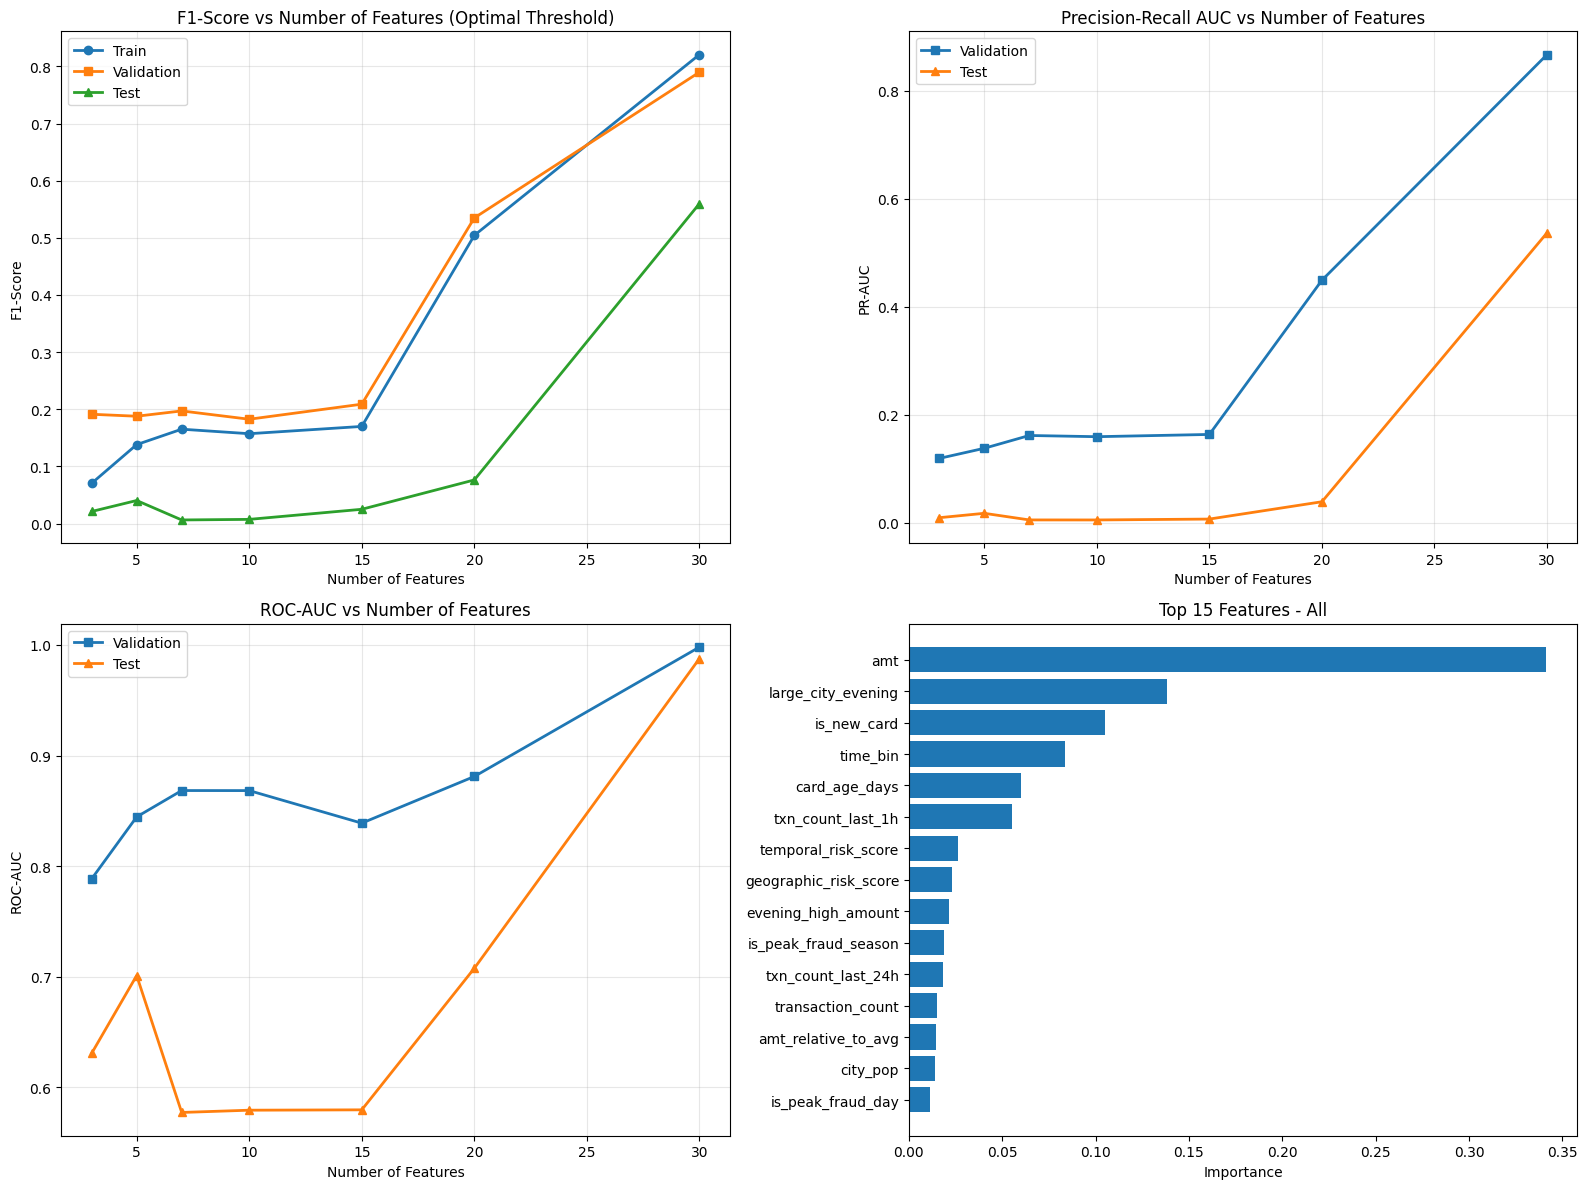

In [15]:
# ============================================================
# COMPARE MODEL PERFORMANCE ACROSS FEATURE SETS
# ============================================================

# Create comparison DataFrame with optimal threshold metrics
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Feature Set': result['name'],
        'N Features': result['n_features'],
        'Threshold': result['metrics'].get('optimal_threshold', 0.5),
        'Train F1': result['metrics']['train']['f1_score'],
        'Val F1': result['metrics']['val']['f1_score'],
        'Test F1': result['metrics']['test']['f1_score'],
        'Val PR-AUC': result['metrics']['val']['pr_auc'],
        'Test PR-AUC': result['metrics']['test']['pr_auc'],
        'Val ROC-AUC': result['metrics']['val']['roc_auc'],
        'Test ROC-AUC': result['metrics']['test']['roc_auc'],
        'Test Precision': result['metrics']['test']['precision'],
        'Test Recall': result['metrics']['test']['recall']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison (at optimal threshold):")
print(comparison_df.to_string(index=False))

# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score comparison
axes[0, 0].plot(comparison_df['N Features'], comparison_df['Train F1'], 'o-', label='Train', linewidth=2)
axes[0, 0].plot(comparison_df['N Features'], comparison_df['Val F1'], 's-', label='Validation', linewidth=2)
axes[0, 0].plot(comparison_df['N Features'], comparison_df['Test F1'], '^-', label='Test', linewidth=2)
axes[0, 0].set_xlabel('Number of Features')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('F1-Score vs Number of Features (Optimal Threshold)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PR-AUC comparison
axes[0, 1].plot(comparison_df['N Features'], comparison_df['Val PR-AUC'], 's-', label='Validation', linewidth=2)
axes[0, 1].plot(comparison_df['N Features'], comparison_df['Test PR-AUC'], '^-', label='Test', linewidth=2)
axes[0, 1].set_xlabel('Number of Features')
axes[0, 1].set_ylabel('PR-AUC')
axes[0, 1].set_title('Precision-Recall AUC vs Number of Features')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ROC-AUC comparison
axes[1, 0].plot(comparison_df['N Features'], comparison_df['Val ROC-AUC'], 's-', label='Validation', linewidth=2)
axes[1, 0].plot(comparison_df['N Features'], comparison_df['Test ROC-AUC'], '^-', label='Test', linewidth=2)
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_title('ROC-AUC vs Number of Features')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature importance for best model (highest validation F1)
best_idx = comparison_df['Val F1'].idxmax()
best_result = all_results[best_idx]
importance_df_best = best_result['feature_importance'].head(15)

axes[1, 1].barh(range(len(importance_df_best)), importance_df_best['importance'].values)
axes[1, 1].set_yticks(range(len(importance_df_best)))
axes[1, 1].set_yticklabels(importance_df_best['feature'].values)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title(f'Top 15 Features - {best_result["name"]}')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [16]:
# ============================================================
# IDENTIFY BEST MODEL
# ============================================================

# Find best model based on validation F1-score
best_idx = comparison_df['Val F1'].idxmax()
best_result = all_results[best_idx]
best_model = best_result['model']

print("=" * 80)
print("BEST MODEL SELECTION")
print("=" * 80)
print(f"\nBest Model: {best_result['name']}")
print(f"  Number of Features: {best_result['n_features']}")
print(f"  Optimal Threshold: {best_result['metrics'].get('optimal_threshold', 0.5):.4f}")
print(f"\nValidation Performance (at optimal threshold):")
print(f"  F1-Score: {best_result['metrics']['val']['f1_score']:.4f}")
print(f"  Precision: {best_result['metrics']['val']['precision']:.4f}")
print(f"  Recall: {best_result['metrics']['val']['recall']:.4f}")
print(f"  PR-AUC: {best_result['metrics']['val']['pr_auc']:.4f}")
print(f"  ROC-AUC: {best_result['metrics']['val']['roc_auc']:.4f}")
print(f"\nTest Performance (at optimal threshold):")
print(f"  F1-Score: {best_result['metrics']['test']['f1_score']:.4f}")
print(f"  Precision: {best_result['metrics']['test']['precision']:.4f}")
print(f"  Recall: {best_result['metrics']['test']['recall']:.4f}")
print(f"  PR-AUC: {best_result['metrics']['test']['pr_auc']:.4f}")
print(f"  ROC-AUC: {best_result['metrics']['test']['roc_auc']:.4f}")

print(f"\nTop 10 Most Important Features:")
print(best_result['feature_importance'].head(10).to_string(index=False))

BEST MODEL SELECTION

Best Model: All
  Number of Features: 30
  Optimal Threshold: 0.9784

Validation Performance (at optimal threshold):
  F1-Score: 0.7899
  Precision: 0.8254
  Recall: 0.7574
  PR-AUC: 0.8666
  ROC-AUC: 0.9980

Test Performance (at optimal threshold):
  F1-Score: 0.5598
  Precision: 0.6059
  Recall: 0.5203
  PR-AUC: 0.5364
  ROC-AUC: 0.9876

Top 10 Most Important Features:
              feature  importance
                  amt    0.341022
   large_city_evening    0.138068
          is_new_card    0.105054
             time_bin    0.083719
        card_age_days    0.060151
    txn_count_last_1h    0.055086
  temporal_risk_score    0.026176
geographic_risk_score    0.023218
  evening_high_amount    0.021469
 is_peak_fraud_season    0.018661


## 7. Logistic Regression and Random Forest

Train additional supervised models (Logistic Regression, Random Forest) using all features and compare against the best XGBoost result from iterative feature addition.

In [17]:
# ============================================================
# LOGISTIC REGRESSION
# ============================================================
from sklearn.linear_model import LogisticRegression

X_train_all = train_df[feature_cols].values
y_train_all = train_df['is_fraud'].values
X_val_all = val_df[feature_cols].values
y_val_all = val_df['is_fraud'].values
X_test_all = test_df[feature_cols].values
y_test_all = test_df['is_fraud'].values

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    random_state=42,
    C=1.0
)
lr_model.fit(X_train_all, y_train_all)

# Threshold tuning
y_val_proba_lr = lr_model.predict_proba(X_val_all)[:, 1]
lr_thresh, lr_val_f1 = find_best_threshold(y_val_all, y_val_proba_lr)
print(f"LR optimal threshold: {lr_thresh:.4f}, Val F1: {lr_val_f1:.4f}")

# Evaluate at optimal threshold
y_test_proba_lr = lr_model.predict_proba(X_test_all)[:, 1]
y_test_pred_lr = (y_test_proba_lr >= lr_thresh).astype(int)
y_val_pred_lr = (y_val_proba_lr >= lr_thresh).astype(int)

lr_val_metrics = {
    'f1_score': f1_score(y_val_all, y_val_pred_lr),
    'precision': precision_score(y_val_all, y_val_pred_lr, zero_division=0),
    'recall': recall_score(y_val_all, y_val_pred_lr, zero_division=0),
    'roc_auc': roc_auc_score(y_val_all, y_val_proba_lr),
    'pr_auc': average_precision_score(y_val_all, y_val_proba_lr)
}

lr_test_metrics = {
    'f1_score': f1_score(y_test_all, y_test_pred_lr),
    'precision': precision_score(y_test_all, y_test_pred_lr, zero_division=0),
    'recall': recall_score(y_test_all, y_test_pred_lr, zero_division=0),
    'roc_auc': roc_auc_score(y_test_all, y_test_proba_lr),
    'pr_auc': average_precision_score(y_test_all, y_test_proba_lr)
}

print("\nLogistic Regression - Validation:")
for k, v in lr_val_metrics.items():
    print(f"  {k}: {v:.4f}")
print("\nLogistic Regression - Test:")
for k, v in lr_test_metrics.items():
    print(f"  {k}: {v:.4f}")

LR optimal threshold: 0.9839, Val F1: 0.4670



Logistic Regression - Validation:
  f1_score: 0.4670
  precision: 0.4253
  recall: 0.5179
  roc_auc: 0.9487
  pr_auc: 0.2927

Logistic Regression - Test:
  f1_score: 0.2751
  precision: 0.2105
  recall: 0.3967
  roc_auc: 0.8573
  pr_auc: 0.1220


In [18]:
# ============================================================
# RANDOM FOREST
# ============================================================
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_all, y_train_all)

# Threshold tuning
y_val_proba_rf = rf_model.predict_proba(X_val_all)[:, 1]
rf_thresh, rf_val_f1 = find_best_threshold(y_val_all, y_val_proba_rf)
print(f"RF optimal threshold: {rf_thresh:.4f}, Val F1: {rf_val_f1:.4f}")

# Evaluate at optimal threshold
y_test_proba_rf = rf_model.predict_proba(X_test_all)[:, 1]
y_test_pred_rf = (y_test_proba_rf >= rf_thresh).astype(int)
y_val_pred_rf = (y_val_proba_rf >= rf_thresh).astype(int)

rf_val_metrics = {
    'f1_score': f1_score(y_val_all, y_val_pred_rf),
    'precision': precision_score(y_val_all, y_val_pred_rf, zero_division=0),
    'recall': recall_score(y_val_all, y_val_pred_rf, zero_division=0),
    'roc_auc': roc_auc_score(y_val_all, y_val_proba_rf),
    'pr_auc': average_precision_score(y_val_all, y_val_proba_rf)
}

rf_test_metrics = {
    'f1_score': f1_score(y_test_all, y_test_pred_rf),
    'precision': precision_score(y_test_all, y_test_pred_rf, zero_division=0),
    'recall': recall_score(y_test_all, y_test_pred_rf, zero_division=0),
    'roc_auc': roc_auc_score(y_test_all, y_test_proba_rf),
    'pr_auc': average_precision_score(y_test_all, y_test_proba_rf)
}

print("\nRandom Forest - Validation:")
for k, v in rf_val_metrics.items():
    print(f"  {k}: {v:.4f}")
print("\nRandom Forest - Test:")
for k, v in rf_test_metrics.items():
    print(f"  {k}: {v:.4f}")

# Feature importance comparison
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRF Top 10 Features:")
print(rf_importance.head(10).to_string(index=False))

RF optimal threshold: 0.8248, Val F1: 0.6968



Random Forest - Validation:
  f1_score: 0.6968
  precision: 0.7894
  recall: 0.6236
  roc_auc: 0.9900
  pr_auc: 0.7527

Random Forest - Test:
  f1_score: 0.4393
  precision: 0.3925
  recall: 0.4988
  roc_auc: 0.9670
  pr_auc: 0.3612

RF Top 10 Features:
                feature  importance
                    amt    0.313095
    amt_relative_to_avg    0.227237
            is_new_card    0.101608
    temporal_risk_score    0.053357
evening_online_shopping    0.043423
               time_bin    0.040817
                   hour    0.034931
      txn_count_last_1h    0.026131
  geographic_risk_score    0.024713
    evening_high_amount    0.020454


## 8. Hyperparameter Tuning: XGBoost with Optuna

Use Bayesian optimization (Optuna) to find the best XGBoost hyperparameters, optimizing for validation PR-AUC (threshold-invariant).

In [19]:
# ============================================================
# OPTUNA HYPERPARAMETER TUNING FOR XGBOOST
# ============================================================
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def xgb_objective(trial: optuna.Trial) -> float:
    """Optuna objective: maximize validation PR-AUC."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_all, y_train_all, eval_set=[(X_val_all, y_val_all)], verbose=False)

    y_val_proba = model.predict_proba(X_val_all)[:, 1]
    return average_precision_score(y_val_all, y_val_proba)

study = optuna.create_study(direction='maximize', study_name='xgb_tuning')
study.optimize(xgb_objective, n_trials=30, show_progress_bar=True)

print(f"\nBest trial PR-AUC: {study.best_value:.4f}")
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

  0%|          | 0/30 [00:00<?, ?it/s]


Best trial PR-AUC: 0.8719
Best hyperparameters:
  n_estimators: 450
  max_depth: 6
  learning_rate: 0.03572609691196603
  subsample: 0.7758512642396294
  colsample_bytree: 0.8932675237644372
  min_child_weight: 10


Tuned XGB optimal threshold: 0.9750, Val F1: 0.7935



XGBoost (Tuned) - Validation:
  f1_score: 0.7935
  precision: 0.8313
  recall: 0.7589
  roc_auc: 0.9982
  pr_auc: 0.8719

XGBoost (Tuned) - Test:
  f1_score: 0.6075
  precision: 0.6470
  recall: 0.5725
  roc_auc: 0.9880
  pr_auc: 0.6195


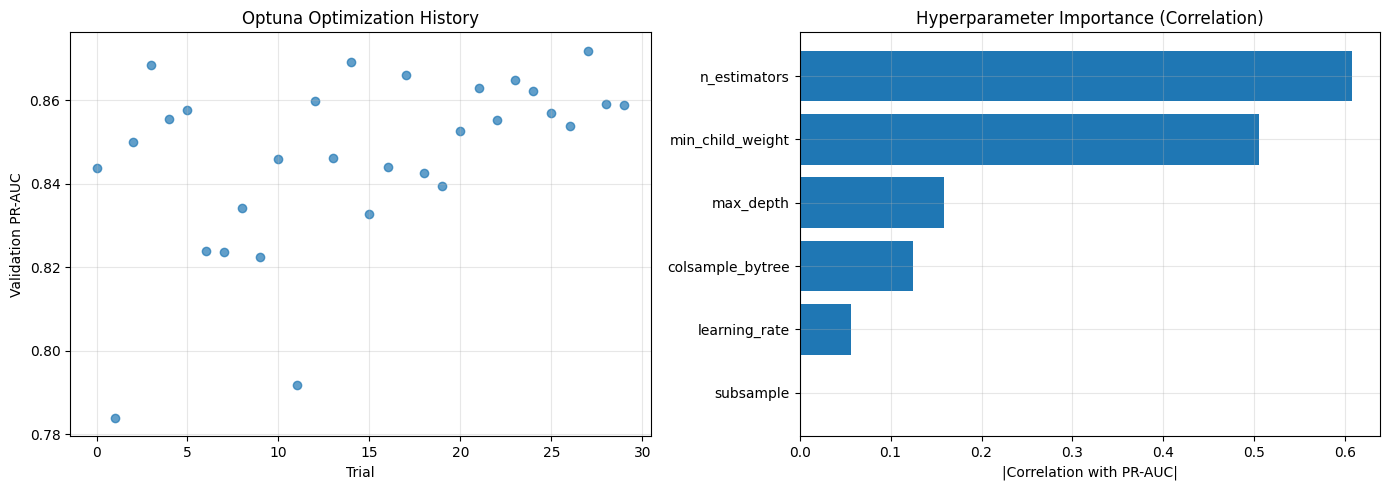

In [20]:
# ============================================================
# EVALUATE TUNED XGBOOST
# ============================================================

xgb_tuned = xgb.XGBClassifier(
    **study.best_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_tuned.fit(X_train_all, y_train_all, eval_set=[(X_val_all, y_val_all)], verbose=False)

y_val_proba_tuned = xgb_tuned.predict_proba(X_val_all)[:, 1]
xgb_tuned_thresh, xgb_tuned_val_f1 = find_best_threshold(y_val_all, y_val_proba_tuned)
print(f"Tuned XGB optimal threshold: {xgb_tuned_thresh:.4f}, Val F1: {xgb_tuned_val_f1:.4f}")

y_test_proba_tuned = xgb_tuned.predict_proba(X_test_all)[:, 1]
y_test_pred_tuned = (y_test_proba_tuned >= xgb_tuned_thresh).astype(int)
y_val_pred_tuned = (y_val_proba_tuned >= xgb_tuned_thresh).astype(int)

xgb_tuned_val_metrics = {
    'f1_score': f1_score(y_val_all, y_val_pred_tuned),
    'precision': precision_score(y_val_all, y_val_pred_tuned, zero_division=0),
    'recall': recall_score(y_val_all, y_val_pred_tuned, zero_division=0),
    'roc_auc': roc_auc_score(y_val_all, y_val_proba_tuned),
    'pr_auc': average_precision_score(y_val_all, y_val_proba_tuned)
}

xgb_tuned_test_metrics = {
    'f1_score': f1_score(y_test_all, y_test_pred_tuned),
    'precision': precision_score(y_test_all, y_test_pred_tuned, zero_division=0),
    'recall': recall_score(y_test_all, y_test_pred_tuned, zero_division=0),
    'roc_auc': roc_auc_score(y_test_all, y_test_proba_tuned),
    'pr_auc': average_precision_score(y_test_all, y_test_proba_tuned)
}

print("\nXGBoost (Tuned) - Validation:")
for k, v in xgb_tuned_val_metrics.items():
    print(f"  {k}: {v:.4f}")
print("\nXGBoost (Tuned) - Test:")
for k, v in xgb_tuned_test_metrics.items():
    print(f"  {k}: {v:.4f}")

# Optuna trial visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
trials_df = study.trials_dataframe()
axes[0].scatter(range(len(trials_df)), trials_df['value'], alpha=0.7)
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Validation PR-AUC')
axes[0].set_title('Optuna Optimization History')
axes[0].grid(True, alpha=0.3)

# Param importance (manual: top params by correlation with score)
param_cols = [c for c in trials_df.columns if c.startswith('params_')]
if len(param_cols) > 0:
    correlations = trials_df[param_cols].corrwith(trials_df['value']).abs().sort_values(ascending=True)
    correlations.index = [c.replace('params_', '') for c in correlations.index]
    axes[1].barh(range(len(correlations)), correlations.values)
    axes[1].set_yticks(range(len(correlations)))
    axes[1].set_yticklabels(correlations.index)
    axes[1].set_xlabel('|Correlation with PR-AUC|')
    axes[1].set_title('Hyperparameter Importance (Correlation)')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'optuna_xgb_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Full Model Comparison (LR, RF, XGBoost default, XGBoost tuned)

In [21]:
# ============================================================
# FULL MODEL COMPARISON TABLE
# ============================================================

# Best XGBoost from iterative feature addition (Section 5)
xgb_default_val = best_result['metrics']['val']
xgb_default_test = best_result['metrics']['test']
xgb_default_thresh = best_result['metrics'].get('optimal_threshold', 0.5)

all_models_comparison = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'Threshold': lr_thresh,
        'Val F1': lr_val_metrics['f1_score'],
        'Val PR-AUC': lr_val_metrics['pr_auc'],
        'Val ROC-AUC': lr_val_metrics['roc_auc'],
        'Test F1': lr_test_metrics['f1_score'],
        'Test PR-AUC': lr_test_metrics['pr_auc'],
        'Test ROC-AUC': lr_test_metrics['roc_auc'],
        'Test Precision': lr_test_metrics['precision'],
        'Test Recall': lr_test_metrics['recall'],
    },
    {
        'Model': 'Random Forest',
        'Threshold': rf_thresh,
        'Val F1': rf_val_metrics['f1_score'],
        'Val PR-AUC': rf_val_metrics['pr_auc'],
        'Val ROC-AUC': rf_val_metrics['roc_auc'],
        'Test F1': rf_test_metrics['f1_score'],
        'Test PR-AUC': rf_test_metrics['pr_auc'],
        'Test ROC-AUC': rf_test_metrics['roc_auc'],
        'Test Precision': rf_test_metrics['precision'],
        'Test Recall': rf_test_metrics['recall'],
    },
    {
        'Model': 'XGBoost (default)',
        'Threshold': xgb_default_thresh,
        'Val F1': xgb_default_val['f1_score'],
        'Val PR-AUC': xgb_default_val['pr_auc'],
        'Val ROC-AUC': xgb_default_val['roc_auc'],
        'Test F1': xgb_default_test['f1_score'],
        'Test PR-AUC': xgb_default_test['pr_auc'],
        'Test ROC-AUC': xgb_default_test['roc_auc'],
        'Test Precision': xgb_default_test['precision'],
        'Test Recall': xgb_default_test['recall'],
    },
    {
        'Model': 'XGBoost (Optuna-tuned)',
        'Threshold': xgb_tuned_thresh,
        'Val F1': xgb_tuned_val_metrics['f1_score'],
        'Val PR-AUC': xgb_tuned_val_metrics['pr_auc'],
        'Val ROC-AUC': xgb_tuned_val_metrics['roc_auc'],
        'Test F1': xgb_tuned_test_metrics['f1_score'],
        'Test PR-AUC': xgb_tuned_test_metrics['pr_auc'],
        'Test ROC-AUC': xgb_tuned_test_metrics['roc_auc'],
        'Test Precision': xgb_tuned_test_metrics['precision'],
        'Test Recall': xgb_tuned_test_metrics['recall'],
    },
])

print("=" * 80)
print("FULL SUPERVISED MODEL COMPARISON")
print("=" * 80)
print(all_models_comparison.to_string(index=False))

# Save updated comparison
all_models_comparison.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
print(f"\nSaved to: {RESULTS_DIR / 'model_comparison.csv'}")

FULL SUPERVISED MODEL COMPARISON
                 Model  Threshold   Val F1  Val PR-AUC  Val ROC-AUC  Test F1  Test PR-AUC  Test ROC-AUC  Test Precision  Test Recall
   Logistic Regression   0.983907 0.467041    0.292713     0.948747 0.275093     0.121964      0.857311        0.210539     0.396737
         Random Forest   0.824839 0.696785    0.752674     0.990041 0.439335     0.361188      0.966979        0.392517     0.498834
     XGBoost (default)   0.978446 0.789943    0.866562     0.997986 0.559819     0.536425      0.987574        0.605863     0.520280
XGBoost (Optuna-tuned)   0.974986 0.793496    0.871892     0.998230 0.607470     0.619519      0.988000        0.646997     0.572494

Saved to: /home/alireza/Desktop/projects/fraud-shield-ai/results/model_comparison.csv


## 10. Save Best Model

In [22]:
# ============================================================
# SAVE BEST MODEL AND RESULTS
# ============================================================

# Determine overall best supervised model by validation PR-AUC
supervised_models = {
    'Logistic Regression': (lr_model, lr_thresh, lr_val_metrics, lr_test_metrics),
    'Random Forest': (rf_model, rf_thresh, rf_val_metrics, rf_test_metrics),
    'XGBoost (default)': (best_model, xgb_default_thresh, xgb_default_val, xgb_default_test),
    'XGBoost (Optuna-tuned)': (xgb_tuned, xgb_tuned_thresh, xgb_tuned_val_metrics, xgb_tuned_test_metrics),
}

overall_best_name = max(supervised_models, key=lambda k: supervised_models[k][2]['pr_auc'])
overall_best_model, overall_best_thresh, overall_best_val, overall_best_test = supervised_models[overall_best_name]
print(f"Overall best supervised model: {overall_best_name} (Val PR-AUC: {overall_best_val['pr_auc']:.4f})")

# Save best XGBoost model (default or tuned -- whichever has higher val PR-AUC)
model_path = MODELS_DIR / 'xgb_best_model.pkl'
xgb_best_for_save = xgb_tuned if xgb_tuned_val_metrics['pr_auc'] >= xgb_default_val['pr_auc'] else best_model
xgb_best_thresh_save = xgb_tuned_thresh if xgb_tuned_val_metrics['pr_auc'] >= xgb_default_val['pr_auc'] else xgb_default_thresh
joblib.dump(xgb_best_for_save, model_path)
print(f"Best XGBoost model saved: {model_path}")

# Save LR and RF models
joblib.dump(lr_model, MODELS_DIR / 'lr_model.pkl')
joblib.dump(rf_model, MODELS_DIR / 'rf_model.pkl')
print(f"LR model saved: {MODELS_DIR / 'lr_model.pkl'}")
print(f"RF model saved: {MODELS_DIR / 'rf_model.pkl'}")

# Save model metadata
model_metadata = {
    'model_name': overall_best_name,
    'features': feature_cols,
    'n_features': len(feature_cols),
    'optimal_threshold': overall_best_thresh,
    'val_metrics': overall_best_val,
    'test_metrics': overall_best_test,
    'scale_pos_weight': scale_pos_weight,
    'optuna_best_params': study.best_params,
    'training_date': datetime.now().isoformat()
}

metadata_path = MODELS_DIR / 'xgb_best_model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"Model metadata saved: {metadata_path}")

# Save iterative feature addition results
all_results_path = RESULTS_DIR / 'iterative_feature_addition_results.pkl'
joblib.dump(all_results, all_results_path)
print(f"Iterative results saved: {all_results_path}")

# Save full comparison (already saved in section 9)
print("\nModel saving complete!")

Overall best supervised model: XGBoost (Optuna-tuned) (Val PR-AUC: 0.8719)
Best XGBoost model saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/xgb_best_model.pkl
LR model saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/lr_model.pkl
RF model saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/rf_model.pkl
Model metadata saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/xgb_best_model_metadata.pkl
Iterative results saved: /home/alireza/Desktop/projects/fraud-shield-ai/results/iterative_feature_addition_results.pkl

Model saving complete!
